<a href="https://colab.research.google.com/github/YiwanChen/shopmania_processed/blob/main/product_category_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Binary classification for product name with LSTM.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
ls /content/drive/MyDrive/shopmamia/

shopmania_category.csv


In [10]:
import numpy as np 
import pandas as pd
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

In [12]:
import tensorflow as tf
import os

In [11]:
os.environ['COLAB_TPU_ADDR']

'10.25.46.106:8470'

In [3]:
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [19]:

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.25.46.106:8470']


In [13]:
df = pd.read_csv("/content/drive/MyDrive/shopmamia/shopmania_category.csv")
df.drop(['Unnamed: 0'], axis= 1, inplace = True)

In [ ]:
df.head()

,cleaned_name,category_lv2,is_biosecurity_insterest
0,boston red sox for men by boston red sox eau d...,Home and office,False
1,twilight central park print,Home and office,False
2,fox print,Home and office,False
3,circulo de papel wall art,Home and office,False
4,hidden path print,Home and office,False


In [ ]:
df.dtypes

cleaned_name                object
category_lv2                object
is_biosecurity_insterest      bool
dtype: object

In [14]:
n_most_common_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['cleaned_name'].values)
sequences = tokenizer.texts_to_sequences(df['cleaned_name'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 64066 unique tokens.


In [15]:
labels = to_categorical(df['is_biosecurity_insterest'], num_classes=2)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.3, random_state=42)

In [17]:
epochs = 5
emb_dim = 128
batch_size = 256

print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

((212674, 100), (212674, 2), (91146, 100), (91146, 2))


In [20]:

with tpu_strategy.scope():

  model = Sequential()
  model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
  model.add(SpatialDropout1D(0.5))
  model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5))
  model.add(Dense(2, activation='relu'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
  print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          1280000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 1,329,538
Trainable params: 1,329,538
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
history = model.fit(X_train, y_train, epochs=epochs, 
                    batch_size=batch_size,validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss',patience=2, 
                                            min_delta=0.0001)])

Epoch 1/5
665/665 [==============================] - 37s 43ms/step - loss: 0.1992 - binary_accuracy: 0.9601 - val_loss: 0.0549 - val_binary_accuracy: 0.9889
Epoch 2/5
665/665 [==============================] - 24s 36ms/step - loss: 0.0470 - binary_accuracy: 0.9909 - val_loss: 0.0514 - val_binary_accuracy: 0.9914
Epoch 3/5
665/665 [==============================] - 24s 36ms/step - loss: 0.0406 - binary_accuracy: 0.9930 - val_loss: 0.0466 - val_binary_accuracy: 0.9919
Epoch 4/5
665/665 [==============================] - 25s 37ms/step - loss: 0.0388 - binary_accuracy: 0.9933 - val_loss: 0.0515 - val_binary_accuracy: 0.9923
Epoch 5/5
665/665 [==============================] - 25s 38ms/step - loss: 0.0349 - binary_accuracy: 0.9942 - val_loss: 0.0514 - val_binary_accuracy: 0.9927


In [28]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2849/2849 [==============================] - 56s 19ms/step - loss: 0.0447 - binary_accuracy: 0.9936
Test set
  Loss: 0.045
  Accuracy: 0.994


In [ ]:
dict(zip(model.metrics_names, accr))

{'loss': 0.0421995185315609, 'binary_accuracy': 0.9935762286186218}

In [ ]:
predicts = model.predict(X_test)

predicts = np.argmax(predicts, axis = 1)

In [ ]:
y_gt = np.argmax(y_test, axis = 1)

In [ ]:
tf.math.confusion_matrix(y_gt, predicts)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[86037,   211],
       [  365,  4533]], dtype=int32)>

In [25]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

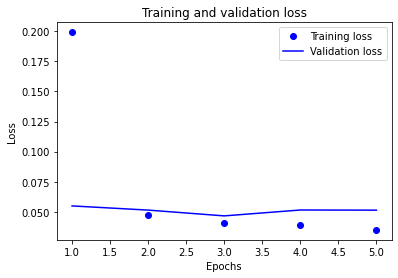

In [26]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
accr

[0.02089022845029831, 0.994031548500061]